# Model free methods: Monte-Carlo Control, Q-Learning, SARSA

In this lab we study the basics of model free methods. Recall that in the model free setting we cannot directly compute the Bellman's operator, thus we must rely on approximations. We will consider Monte Carlo control and two temporal difference approximation techniques: Q-learning (off-policy) and SARSA (on-policy). 


#Q learning

**Frozen lake environment**: 

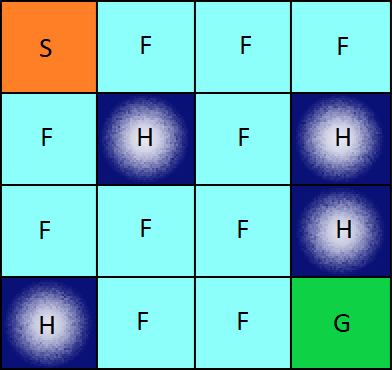

Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

The surface is described using a grid like the following:


SFFF       (S: starting point, safe)

FHFH       (F: frozen surface, safe)

FFFH       (H: hole, fall to your doom)

HFFG       (G: goal, where the frisbee is located)

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

In [1]:
# Necessary imports
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product

Here we create a general class that will be useful for experiments with algorithms that learn tabular Q-function. 

**Excercise: read the code carefully** (the function update_q_function we be provided later).

In [2]:
class GeneralQLearning:
    def __init__(self, env, state_space, action_space, update_q_function, gamma=0.99, epsilon=0.5, min_epsilon=0.1, learning_rate=0.5, epsilon_decay=0.995):
        ''' Parameters explanation: 
        The epsilon for exploration is given by the formula: effective_epsilon = epsilon * epsilon_decay_factor + min_epsilon
        At every step epsilon_decay_factor is multiplied buy epsilon_decay.'''
        self.state_space = state_space
        self.action_space = action_space
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.learning_rate = learning_rate
        self.env = env
        self.update_q_function = update_q_function
        self.epsilon_decay = epsilon_decay
        self.reset_agent()

    def reset_agent(self):
        # We initialize Q-table
        self.Q = {s : {a : random.random() for a in self.action_space} for s in self.state_space}
        # Es
        self.epsilon_decay_factor = 1
        self.env.reset()

    def get_effective_epsilon(self):
        return self.epsilon * self.epsilon_decay_factor

    def act(self, observation):
        if random.random() < (self.epsilon-self.min_epsilon)*self.epsilon_decay_factor + self.min_epsilon:
            return random.randint(0,3)
        else:
            action_values = np.array([self.Q[observation][action] for action in range(4)])
            return np.argmax(action_values)

    def run_one_episode(self):
        observation = self.env.reset()
        done = False
        total_reward = 0
        while not done:
            action = self.act(observation)
            next_observation, reward, done, _ = self.env.step(action)
            next_action = self.act(next_observation)
            total_reward += reward
            self.update_q_function(self.Q, done, observation, action, reward,
                                   next_observation, next_action, self.gamma,
                                   self.learning_rate, self.action_space
                                   )
            observation = next_observation
        self.epsilon_decay_factor *= self.epsilon_decay
        return total_reward

We will use different *update_q_function* for different algorithms. Let us start with vanilla Q-learning. 

**Excercise: implement tabular_q_update function that evaluates new Q-value for a state-action pair encoutered by the algorithm**. The formula:  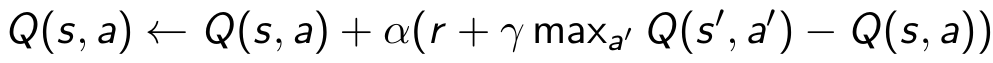

Hint: be carefull with the last state-action pair of a given episode.

In [3]:
def tabular_q_update(Q, done, observation, action, reward, next_observation, next_action, gamma, learning_rate, action_space):
    if not done:
        max_q = max(Q[next_observation].values())
    else:
        max_q = 0
  
    Q[observation][action] = Q[observation][action] + \
                             learning_rate * (reward + gamma*max_q - Q[observation][action])

Let us test the performance. Execute the next cell:

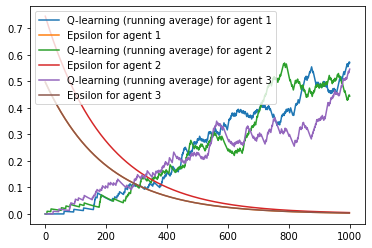

In [4]:
# Test Q- learning performance
env = gym.make('FrozenLake-v0')
agent1 = GeneralQLearning(env, 
                         state_space=range(16), 
                         action_space=range(4), 
                         update_q_function=tabular_q_update, 
                         gamma=0.99, 
                         epsilon=0.5,
                         min_epsilon=0, 
                         learning_rate=0.75)

agent2 = GeneralQLearning(env, 
                         state_space=range(16),
                         action_space=range(4),
                         update_q_function=tabular_q_update,
                         gamma=0.99, 
                         epsilon=0.75,
                         min_epsilon=0,
                         learning_rate=0.5)
                         
agent3 = GeneralQLearning(env, 
                         state_space=range(16),
                         action_space=range(4),
                         update_q_function=tabular_q_update,
                         gamma=0.99, 
                         epsilon=0.5,
                         min_epsilon=0, 
                         learning_rate=0.75)

agents = [agent1, agent2, agent3]
for j, agent in enumerate(agents):
    running_avg = [0]
    epsilon = []
    for i in range(10**3):
        # agent.run_one_episode()
        agent_return = agent.run_one_episode()
        running_avg.append(0.01*agent_return + 0.99*running_avg[-1])
        epsilon.append(agent.get_effective_epsilon())
    plt.plot(running_avg, label=f"Q-learning (running average) for agent {j+1}")
    plt.plot(epsilon, label=f"Epsilon for agent {j+1}")

plt.legend(loc="upper left")
plt.show()

As you can see, the algorithm is not monotonically improving, the process is rather rough. 

**Exercise: find a good set of algorithm parameters.** The good parameters provide some stability of the learning and make the algorithm converge to high rewards. 

Hint: modify the code in the cell above to plot several performance curves on one graph to easily compare the performance.

# Q-learning vs SARSA

In this section we will see how SARSA compares to Q-learning in a dangerous environment. 

**Cliff walking environment**
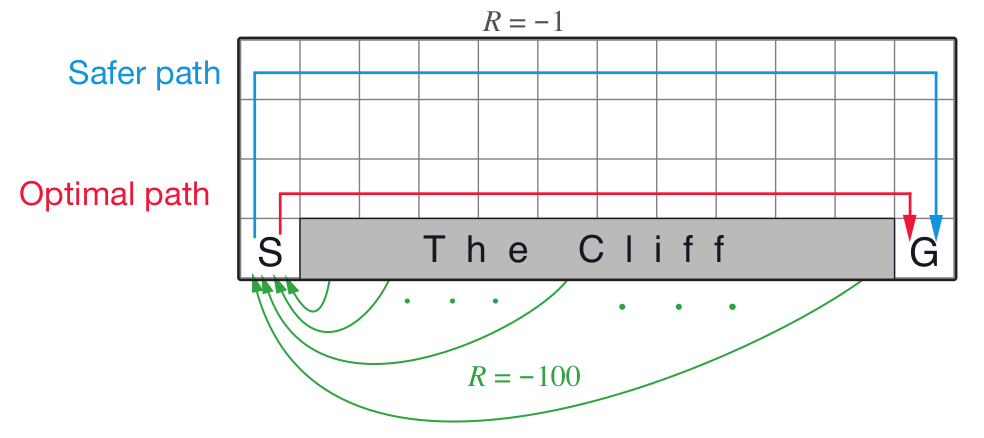

We provide an implementation of the Cliff walking env. Read the code below.

In [5]:
# Here we implement the Cliff walking env
def clip(x, min_val, max_val):
    return sorted((min_val, x, max_val))[1]

class CliffWalkingEnv:
    def __init__(self, length=12, height=4):
        self.length = length
        self.height = height
        self.position = (0,0)
        self.target_position = (self.length-1, 0)
        self.action_to_move = {
            0: (-1,0),
            1: (1,0),
            2: (0,-1),
            3: (0,1)}

    def reset(self):
        self.position = (0, 0)
        return self.position

    def move(self, direction):
        self.position = tuple(self.position[i] + direction[i] for i in range(2))
        self.position = (
            clip(0, self.position[0], self.length-1),
            clip(0, self.position[1], self.height-1)
        )

    def step(self, action):
        self.move(self.action_to_move[action])
        done = False
        reward = -1
        if self.position == self.target_position:
            done = True
        elif 1 < self.position[0] < self.length-1 and self.position[1] == 0:
            reward = -100
            done = True
        return self.position, reward, done, {}

Let us create the CliffWalkingEnv and its state space:

In [6]:
env = CliffWalkingEnv(12,4)
cliff_state_space = [(x,y) for (x, y) in product(range(env.length), range(env.height))]

**Exercise: implement sarsa_q_update function that performs on-policy evaluation of the Q-values.** Use the formula:

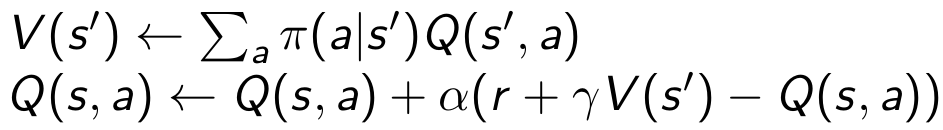

Hints:
- in our case policy is deterministic
- be carefull with the states that are last in the epizode 

In [7]:
def sarsa_q_update(Q, done, observation, action, reward, next_observation, next_action, gamma, learning_rate, action_space):
    if not done:
        next_v = Q[next_observation][next_action]
    else:
        next_v = 0
                            
    Q[observation][action] = Q[observation][action] + \
                             learning_rate * (reward + gamma*next_v - Q[observation][action])

Here the parameter min_epsilon comes useful. We can use it to set the minimul level of exploration, thus a introduce some unevitable danger for the agent. Let us compare SARSA with Q-learning for different values of min_epsilon.

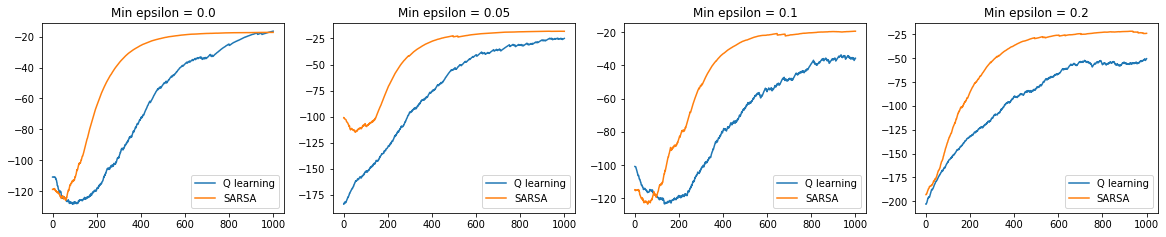

In [8]:
q_agent = GeneralQLearning(env, 
                         state_space=cliff_state_space, 
                         action_space=range(4), 
                         update_q_function=tabular_q_update, 
                         gamma=0.995, 
                         epsilon=0.5,
                         min_epsilon=0.1, 
                         learning_rate=0.05)

sarsa_agent = GeneralQLearning(env, 
                         state_space=cliff_state_space, 
                         action_space=range(4), 
                         update_q_function=sarsa_q_update,
                         gamma=0.99, 
                         epsilon=0.6,
                         min_epsilon=0.1, 
                         learning_rate=0.2)

min_epsilon_vals = [0.0, 0.05, 0.1, 0.2]
fig, axs = plt.subplots(1, len(min_epsilon_vals), figsize=(5*len(min_epsilon_vals),3.5))

for num, min_epsilon in enumerate(min_epsilon_vals):
  q_agent.min_epsilon = min_epsilon
  sarsa_agent.min_epsilon = min_epsilon
  q_agent.reset_agent()
  sarsa_agent.reset_agent()
  q_running_avg = []
  sarsa_running_avg = []
  for i in range(10**3):
      # q_agent.run_one_episode()
      q_agent_return = q_agent.run_one_episode()
      # sarsa_agent.run_one_episode()
      sarsa_agent_return = sarsa_agent.run_one_episode()
      if i == 0:
        q_running_avg.append(q_agent_return)
        sarsa_running_avg.append(sarsa_agent_return)
      q_running_avg.append(0.01*q_agent_return + 0.99*q_running_avg[-1])
      sarsa_running_avg.append(0.01 * sarsa_agent_return + 0.99 * sarsa_running_avg[-1])
  axs[num].plot(q_running_avg, label="Q learning")
  axs[num].plot(sarsa_running_avg, label="SARSA")
  axs[num].legend(loc="lower right")
  axs[num].title.set_text(f'Min epsilon = {min_epsilon}')
plt.show()

In the above comparison we used the same parameters for Q-learning and SARSA. 
**Exercise: try to find the optimal parameters for SARSA and repeat the above comparison it with the optimized Q-learnig** 

We want to check one more thing: what is the price of training (i.e. the accumulated reward during the whole training) for SARSA and Q-learning. 
**Exercise: fill the function get_accumulated_return_data** and check how both algorith perform during the learning phase.

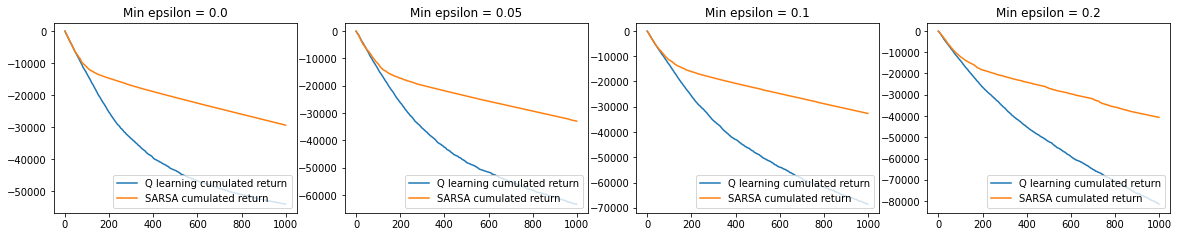

In [9]:
q_cummulated_return = [0]
sarsa_cummulated_return = [0]
min_epsilon_vals = [0.0, 0.05, 0.1, 0.2]
fig, axs = plt.subplots(1, len(min_epsilon_vals), figsize=(5*len(min_epsilon_vals),3.5))

def get_accumulated_return_data(agent, time_horizon):
  # This function returns a list that at the i-th position has the total return 
  # collected during playing the first i epizodes (i.e. sum of returns from epizodes from 0 to i)
  accumulated_return = []
  current_return = 0

  for t in range(time_horizon):
      current_return += agent.run_one_episode()
      accumulated_return.append(current_return)
  return accumulated_return

for num, min_epsilon in enumerate(min_epsilon_vals):
  q_agent.min_epsilon = min_epsilon
  sarsa_agent.min_epsilon = min_epsilon
  q_agent.reset_agent()
  sarsa_agent.reset_agent()
  q_cummulated_return = get_accumulated_return_data(q_agent, 1000)
  sarsa_cummulated_return = get_accumulated_return_data(sarsa_agent, 1000)
  
  axs[num].plot(q_cummulated_return, label="Q learning cumulated return")
  axs[num].plot(sarsa_cummulated_return, label="SARSA cumulated return")
  axs[num].legend(loc="lower right")
  axs[num].title.set_text(f'Min epsilon = {min_epsilon}')
plt.show()

# Monte Carlo Control

We will now use Monte Carlo model-free method to find the optimal strategy for **BlackJack**.

Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer. Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it's called 'usable' at 11. This game is placed with an infinite deck (or with replacement). The game starts with dealer having one face up and one face down card, while player having two face up cards. (Virtually for all Blackjack games today). The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust). After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is  decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1. The observation of a 3-tuple of: the players current sum, the dealer's one showing card (1-10 where 1 is ace), and whether or not the player holds a usable ace (0 or 1).

**Ecercise** Fill the gaps in the code of MCAgent.

In [10]:
class MCAgent:
    def __init__(self, env, policy_evaluation_episodes, learning_rate):
        self.policy_evaluation_episodes = policy_evaluation_episodes
        self.learning_rate = learning_rate
        self.env = env

    def evaluate_policy(self, policy):
        visit_count = defaultdict(lambda: 0)
        return_sum = defaultdict(lambda: 0)
        total_reward = 0
        for _ in range(self.policy_evaluation_episodes):
            seen_obs_acts = set()
            done = False
            obs = self.env.reset()
            episode_return = 0
            trajectory = []

            while not done:
                action = policy.act(obs)
                trajectory.append((obs, action))
                obs, reward, done, _ = self.env.step(action)
                episode_return += reward

            total_reward += episode_return
            for obs_action in trajectory:
                if obs_action not in seen_obs_acts:
                    seen_obs_acts.add(obs_action)
                    return_sum[obs_action] += 1/(visit_count[obs_action]+1) * (episode_return - return_sum[obs_action])
                    visit_count[obs_action] += 1

        Q = {}
        for obs_action in return_sum.keys():
            Q[obs_action] = return_sum[obs_action]
        return Q, total_reward/self.policy_evaluation_episodes

    def train_policy(self, n_epochs, policy):
        running_avg = []
        for _ in range(n_epochs):
            Q_new, avg_return = self.evaluate_policy(policy)
            if len(running_avg) == 0:
                running_avg.append(avg_return)
            else:
                running_avg.append(0.02*avg_return + 0.98*running_avg[-1])
            for key in Q_new.keys():
                policy.Q[key] = (1-self.learning_rate)*policy.Q[key] + self.learning_rate*Q_new[key]
        return running_avg


**Exercise: fill the gaps in EpsilonGreedyPolicy**

In [11]:
class EpsilonGreedyPolicy:
    def __init__(self, epsilon, epsilon_decay):
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.Q = defaultdict(lambda :0)

    def act(self, obs):
        self.epsilon *= self.epsilon_decay
        if random.random() < self.epsilon:
            return random.randint(0, 1)
        else:
            V = [self.Q[(obs, action)] for action in range(2)]
            return np.argmax(V)

Let us test the performance of Monte Carlo control agent:

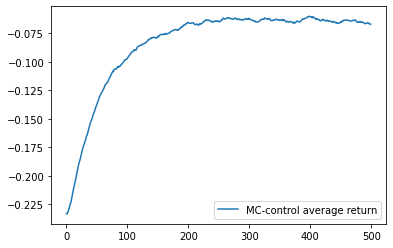

In [12]:
env = gym.make('Blackjack-v0')
mc_hammer = MCAgent(env, 2000, 0.5)
results= mc_hammer.train_policy(500, EpsilonGreedyPolicy(0.5, 0.9999))

plt.plot(results, label="MC-control average return")
plt.legend(loc="lower right")
plt.show()

**Questions:**
- In which situations it is better to use SARSA than Q-learning and in which Q-learning should perform better?
Answer: It's better to use SARSA in situations, when our environment is not perfect and there is a posibility that we don't get an expected new state (for example when controling a robot). It's better to use Q-learning, when we want to get the highest possible reward (because Q-learning gives optimal policy).
- what are the main limits of monte carlo control?
Answer:
  - cannot learn from incomplete sequences,
  - cannot learn before final outcome,
  - is slower than TD
- is monte carlo-control off or on policy algorithm?
Answer: Monte carlo-control is off-policy